   # import libraries

In [42]:
# libraries

import re   
import csv
import nltk
import spacy
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

# import style
import matplotlib.style as style 
sns.set(font_scale=1.5)
style.use('seaborn-pastel')
style.use('seaborn-poster')
from PIL import Image
from wordcloud import WordCloud



In [43]:
# Downloads
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\chand\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\chand\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chand\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\chand\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [44]:
nlp = spacy.load("en_core_web_sm")

In [45]:
# Preprocessing libraries 
import en_core_web_sm
from collections import Counter
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords, wordnet  
from sklearn.feature_extraction.text import CountVectorizer   
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# import data

In [46]:
data = pd.read_csv(r"C:\Users\chand\OneDrive\Desktop\New folder (3)\twitter_sentiment_data.csv")

In [47]:
data.head()

,sentiment,message,tweetid
0,-1,@tiniebeany climate change is an interesting h...,792927353886371840
1,1,RT @NatGeoChannel: Watch #BeforeTheFlood right...,793124211518832641
2,1,Fabulous! Leonardo #DiCaprio's film on #climat...,793124402388832256
3,1,RT @Mick_Fanning: Just watched this amazing do...,793124635873275904
4,2,"RT @cnalive: Pranita Biswasi, a Lutheran from ...",793125156185137153


# remove all the rows where sentiment is 2 

In [48]:
data.drop(data[data['sentiment'] == 2].index , inplace = True)

In [49]:
data.head()

,sentiment,message,tweetid
0,-1,@tiniebeany climate change is an interesting h...,792927353886371840
1,1,RT @NatGeoChannel: Watch #BeforeTheFlood right...,793124211518832641
2,1,Fabulous! Leonardo #DiCaprio's film on #climat...,793124402388832256
3,1,RT @Mick_Fanning: Just watched this amazing do...,793124635873275904
5,0,Unamshow awache kujinga na iko global warming ...,793125429418815489


# check for null values

In [50]:
data.isnull().sum()

sentiment    0
message      0
tweetid      0
dtype: int64

In [51]:
data.shape

(34667, 3)

# check duplicacy of data 


In [52]:
percentofduplicates = round((1-(data['message'].nunique()/len(data['message'])))*100,2)
print(percentofduplicates, '%')

7.8 %


# create a copy of data 


In [53]:
 df = data.copy()

The tweets are divided into 4 sentiments 

[ 1 ] Pro : Tweets that support the belief of man-made climate change.

[ 0 ] Neutral : Tweets that neither support nor refuse beliefs of climate change.

[-1 ] Anti : Tweets that do not support the belief of man-made climate change.

In [54]:
def update(df):


    df = data.copy()
    sentiment = df['sentiment']
    word_sentiment = []

    for i in sentiment :
        if i == 1 :
            word_sentiment.append('Pro')
        elif i == 0 :
            word_sentiment.append('Neutral')
        else :
            word_sentiment.append('Anti')
            
    df['sentiment'] = word_sentiment
    
    return df

df = update(data)
df.head()


,sentiment,message,tweetid
0,Anti,@tiniebeany climate change is an interesting h...,792927353886371840
1,Pro,RT @NatGeoChannel: Watch #BeforeTheFlood right...,793124211518832641
2,Pro,Fabulous! Leonardo #DiCaprio's film on #climat...,793124402388832256
3,Pro,RT @Mick_Fanning: Just watched this amazing do...,793124635873275904
5,Neutral,Unamshow awache kujinga na iko global warming ...,793125429418815489


# Extract hashtags

In [55]:
def hashtag(tweet):
    hashtags = []
    
    for i in tweet:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)
        
    hashtags = sum(hashtags, [])
    frequency = nltk.FreqDist(hashtags)
    
    hashtag = pd.DataFrame({'hashtag': list(frequency.keys()),
                       'count': list(frequency.values())})
    hashtag = hashtag.nlargest(15, columns="count")

    return hashtag

# hashtags for pro, anti and neutral
pro = hashtag(df['message'][df['sentiment'] == 'Pro'])
anti = hashtag(df['message'][df['sentiment'] == 'Anti'])
neutral = hashtag(df['message'][df['sentiment'] == 'Neutral'])

In [56]:
pro.head()

,hashtag,count
2,climate,504
35,climatechange,272
0,BeforeTheFlood,233
70,ActOnClimate,143
20,ParisAgreement,105


In [57]:
anti.head()

,hashtag,count
2,tcot,55
44,MAGA,25
9,climate,23
19,Trump,19
22,climatechange,19


In [58]:
neutral.head()

,hashtag,count
21,climate,52
27,climatechange,34
18,Trump,19
26,ClimateChange,16
28,auspol,13


## remove url's , puntuations , mentions, numbers etc and also convert all letters in lower case 

In [59]:
def clean(tweet):
    #convert into lowercase
    tweet = tweet.lower()
    # remove mentions    
    tweet = re.sub('@[\w]*','',tweet)  
    
    # Remove url's
    tweet = re.sub(r'https?:\/\/.*\/\w*', '', tweet)
    
    # Remove hashtags
    tweet = re.sub(r'#\w*', '', tweet)    
    
    # Remove numbers
    tweet = re.sub(r'\d+', '', tweet)  
    
    # Remove punctuation
    tweet = re.sub(r"[,.;':@#?!\&/$]+\ *", ' ', tweet)
    
    # Remove that funny diamond
    tweet = re.sub(r"U+FFFD ", ' ', tweet)
    
    # Remove extra whitespace
    tweet = re.sub(r'\s\s+', ' ', tweet)
    
    # Remove space in front of tweet
    tweet = tweet.lstrip(' ')                        
    
    return tweet

df['message'] = df['message'].apply(clean)
df['message'] = df['message'].apply(clean)

df.head()

,sentiment,message,tweetid
0,Anti,climate change is an interesting hustle as it ...,792927353886371840
1,Pro,rt watch right here as travels the world to ta...,793124211518832641
2,Pro,fabulous leonardo s film on change is brillian...,793124402388832256
3,Pro,rt just watched this amazing documentary by le...,793124635873275904
5,Neutral,unamshow awache kujinga na iko global warming,793125429418815489


In [60]:
from string import printable
st = set(printable)
df['message'] = df['message'].apply(lambda x: ''.join([" " if  i not in  st else i for i in x]))

In [61]:
df['message'].head()

0    climate change is an interesting hustle as it ...
1    rt watch right here as travels the world to ta...
2    fabulous leonardo s film on change is brillian...
3    rt just watched this amazing documentary by le...
5       unamshow awache kujinga na iko global warming 
Name: message, dtype: object

# Lemmatization, POS tagging and Tokenization 

In [62]:
def lemma(df):
    df['length'] = df['message'].str.len()
    df['tokenized'] = df['message'].apply(word_tokenize)
    df['pos_tags'] = df['tokenized'].apply(nltk.tag.pos_tag)

    def get_wordnet_pos(tag):

        if tag.startswith('J'):
            return wordnet.ADJ

        elif tag.startswith('V'):
            return wordnet.VERB
        
        elif tag.startswith('N'):
            return wordnet.NOUN

        elif tag.startswith('R'):
            return wordnet.ADV
    
        else:
            return wordnet.NOUN
        
    wnl = WordNetLemmatizer()
    df['pos_tags'] = df['pos_tags'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])
    df['lemmatized'] = df['pos_tags'].apply(lambda x: [wnl.lemmatize(word, tag) for word, tag in x])
    df['lemmatized'] = [' '.join(map(str, l)) for l in df['lemmatized']]  
    return df

df = lemma(df)

In [63]:
df.head(20)


,sentiment,message,tweetid,length,tokenized,pos_tags,lemmatized
0,Anti,climate change is an interesting hustle as it ...,792927353886371840,122,"[climate, change, is, an, interesting, hustle,...","[(climate, n), (change, n), (is, v), (an, n), ...",climate change be an interesting hustle a it b...
1,Pro,rt watch right here as travels the world to ta...,793124211518832641,76,"[rt, watch, right, here, as, travels, the, wor...","[(rt, n), (watch, n), (right, r), (here, r), (...",rt watch right here a travel the world to tack...
2,Pro,fabulous leonardo s film on change is brillian...,793124402388832256,61,"[fabulous, leonardo, s, film, on, change, is, ...","[(fabulous, a), (leonardo, n), (s, n), (film, ...",fabulous leonardo s film on change be brillian...
3,Pro,rt just watched this amazing documentary by le...,793124635873275904,104,"[rt, just, watched, this, amazing, documentary...","[(rt, n), (just, r), (watched, v), (this, n), ...",rt just watch this amazing documentary by leon...
5,Neutral,unamshow awache kujinga na iko global warming,793125429418815489,46,"[unamshow, awache, kujinga, na, iko, global, w...","[(unamshow, a), (awache, n), (kujinga, n), (na...",unamshow awache kujinga na iko global warming
8,Neutral,rt leonardo dicaprio s climate change document...,793127097854197761,83,"[rt, leonardo, dicaprio, s, climate, change, d...","[(rt, n), (leonardo, n), (dicaprio, n), (s, a)...",rt leonardo dicaprio s climate change document...
9,Pro,watch right here as travels the world to tackl...,793127346106753028,63,"[watch, right, here, as, travels, the, world, ...","[(watch, n), (right, r), (here, r), (as, n), (...",watch right here a travel the world to tackle ...
10,Pro,rt it s vital that the public health community...,793127915269480448,92,"[rt, it, s, vital, that, the, public, health, ...","[(rt, v), (it, n), (s, a), (vital, a), (that, ...",rt it s vital that the public health community...
11,Pro,bangladesh did not cause climate change so the...,793129746003615745,133,"[bangladesh, did, not, cause, climate, change,...","[(bangladesh, n), (did, v), (not, r), (cause, ...",bangladesh do not cause climate change so the ...
12,Pro,rt watch right here as travels the world to ta...,793129922210492417,76,"[rt, watch, right, here, as, travels, the, wor...","[(rt, n), (watch, n), (right, r), (here, r), (...",rt watch right here a travel the world to tack...


# word frequencies

In [64]:
def frequency(tweet):
    # Count vectorizer excluding english stopwords
    cv = CountVectorizer(stop_words='english', ngram_range = (1,1))
    words = cv.fit_transform(tweet)
    
    # Count the words in the tweets and determine the frequency of each word
    sum_words = words.sum(axis=0)
    words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    
    # Create a dataframe to store the top 25 words and their frequencies
    frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])
    frequency = frequency.head(25)
    
    return frequency

In [65]:
# top 25 words in each class
pro_frequency = frequency(df['lemmatized'][df['sentiment']=='Pro'])
anti_frequency = frequency(df['lemmatized'][df['sentiment']=='Anti'])
neutral_frequency = frequency(df['lemmatized'][df['sentiment']=='Neutral'])

In [66]:
# Extract the words in the tweets for the pro and anti climate change classes 
anti_words = ' '.join([text for text in anti_frequency['word']])
pro_words = ' '.join([text for text in pro_frequency['word']])
neutral_words = ' '.join([text for text in neutral_frequency['word']])

# Create wordcloud for the anti, pro and neutral climate change class
anti_wordcloud = WordCloud(width=800, 
                           height=500, 
                           random_state=110, 
                           max_font_size=110, 
                           background_color='white',
                           colormap="Reds").generate(anti_words)


pro_wordcloud = WordCloud(width=800, 
                          height=500, 
                          random_state=73, 
                          max_font_size=110, 
                          background_color='white',
                          colormap="Greens").generate(pro_words)

neutral_wordcloud = WordCloud(width=800, 
                          height=500, 
                          random_state=10, 
                          max_font_size=110, 
                          background_color='white',
                          colormap="Oranges").generate(neutral_words)


In [67]:
pro_frequency.head()

,word,freq
0,change,19492
1,climate,19241
2,rt,14670
3,global,4292
4,warming,3195


In [68]:
anti_frequency.head()

,word,freq
0,climate,2381
1,change,2310
2,rt,2069
3,global,1972
4,warming,1517


In [69]:
neutral_frequency.head()

,word,freq
0,change,4609
1,climate,4588
2,rt,3493
3,global,3237
4,warming,2628


# extract some entity, organizations etc 

In [70]:
 def extract(tweet):
    def get_people(tweet):  
        words = nlp(tweet)
        people = [w.text for w in words.ents if w.label_== 'PERSON']
        return people
    
    def get_org(tweet):
        words = nlp(tweet)
        org = [w.text for w in words.ents if w.label_== 'ORG']
        return org
    
    def get_gpe(tweet):
        words = nlp(tweet)
        gpe = [w.text for w in words.ents if w.label_== 'GPE']
        return gpe
    # Extract the top 10 people
    people = tweet.apply(lambda x: get_people(x)) 
    people = [x for sub in people for x in sub]
    people_counter = Counter(people)
    people_count = people_counter.most_common(10)
    people, people_count = map(list, zip(*people_count))
    
    # Extract the top 10 organizations
    org = tweet.apply(lambda x: get_org(x)) 
    org = [x for sub in org for x in sub]
    org_counter = Counter(org)
    org_count = org_counter.most_common(10)
    org, org_count = map(list, zip(*org_count))
    
    # Extract the top 10 geopolitical entities
    gpe = tweet.apply(lambda x: get_gpe(x)) 
    gpe = [x for sub in gpe for x in sub]
    gpe_counter = Counter(gpe)
    gpe_count = gpe_counter.most_common(10)
    gpe, gpe_count = map(list, zip(*gpe_count))
     # Create a dataframe to store the information
    df = pd.DataFrame({'people' : people})
    df['geopolitics'] = gpe
    df['organizations'] = org
    
    return df


In [71]:

# Extract top entities for each class
anti_info = extract(df['lemmatized'][df['sentiment']=='Anti'])


In [72]:
display(anti_info)

,people,geopolitics,organizations
0,al gore,paris,un
1,rt obama,america,u s manufacturing non
2,john coleman,california,nasa
3,rt al gore,russia,epa
4,bill nye,manhattan,islam
5,rt steve,china,cnn
6,gore,texas,isn
7,clinton,new york,bc
8,rt gore,chicago,white house
9,don,hollywood,sec


In [73]:
pro_info = extract(df['lemmatized'][df['sentiment']=='Pro'])


In [74]:
display(pro_info)

,people,geopolitics,organizations
0,donald trump,america,epa
1,hrc,china,gop
2,hillary clinton,paris,u s manufacturing non-competiti
3,rt trump,california,exxon
4,rt donald trump,florida,nasa
5,scott,india,bc
6,al gore,uk,congress
7,scott pruitt,russia,un
8,clinton,new york,the white house
9,rt scott,rt america,the united state


In [75]:
neutral_info = extract(df['lemmatized'][df['sentiment']=='Neutral'])

In [76]:
display(neutral_info)

,people,geopolitics,organizations
0,al gore,paris,un
1,donald trump,china,epa
2,rt iceberg,russia,bc
3,nigga,america,cnn
4,rt polar bear,canada,gop
5,clinton,uk,congress
6,rt rt,india,nasa
7,hillary clinton,texas,senate
8,rt obama,chicago,white house
9,rt trump,florida,pentagon


# EDA

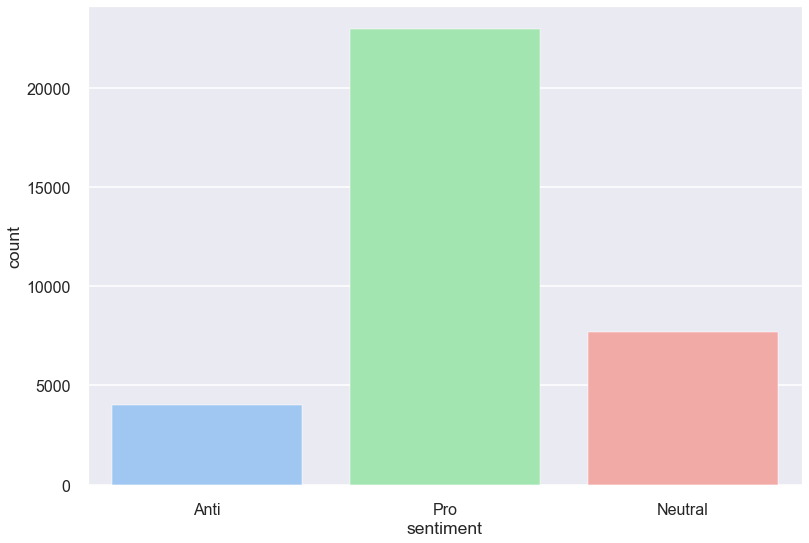

In [77]:
style.use('seaborn-pastel')

sns.countplot(x = df['sentiment'], data = df)
plt.show()

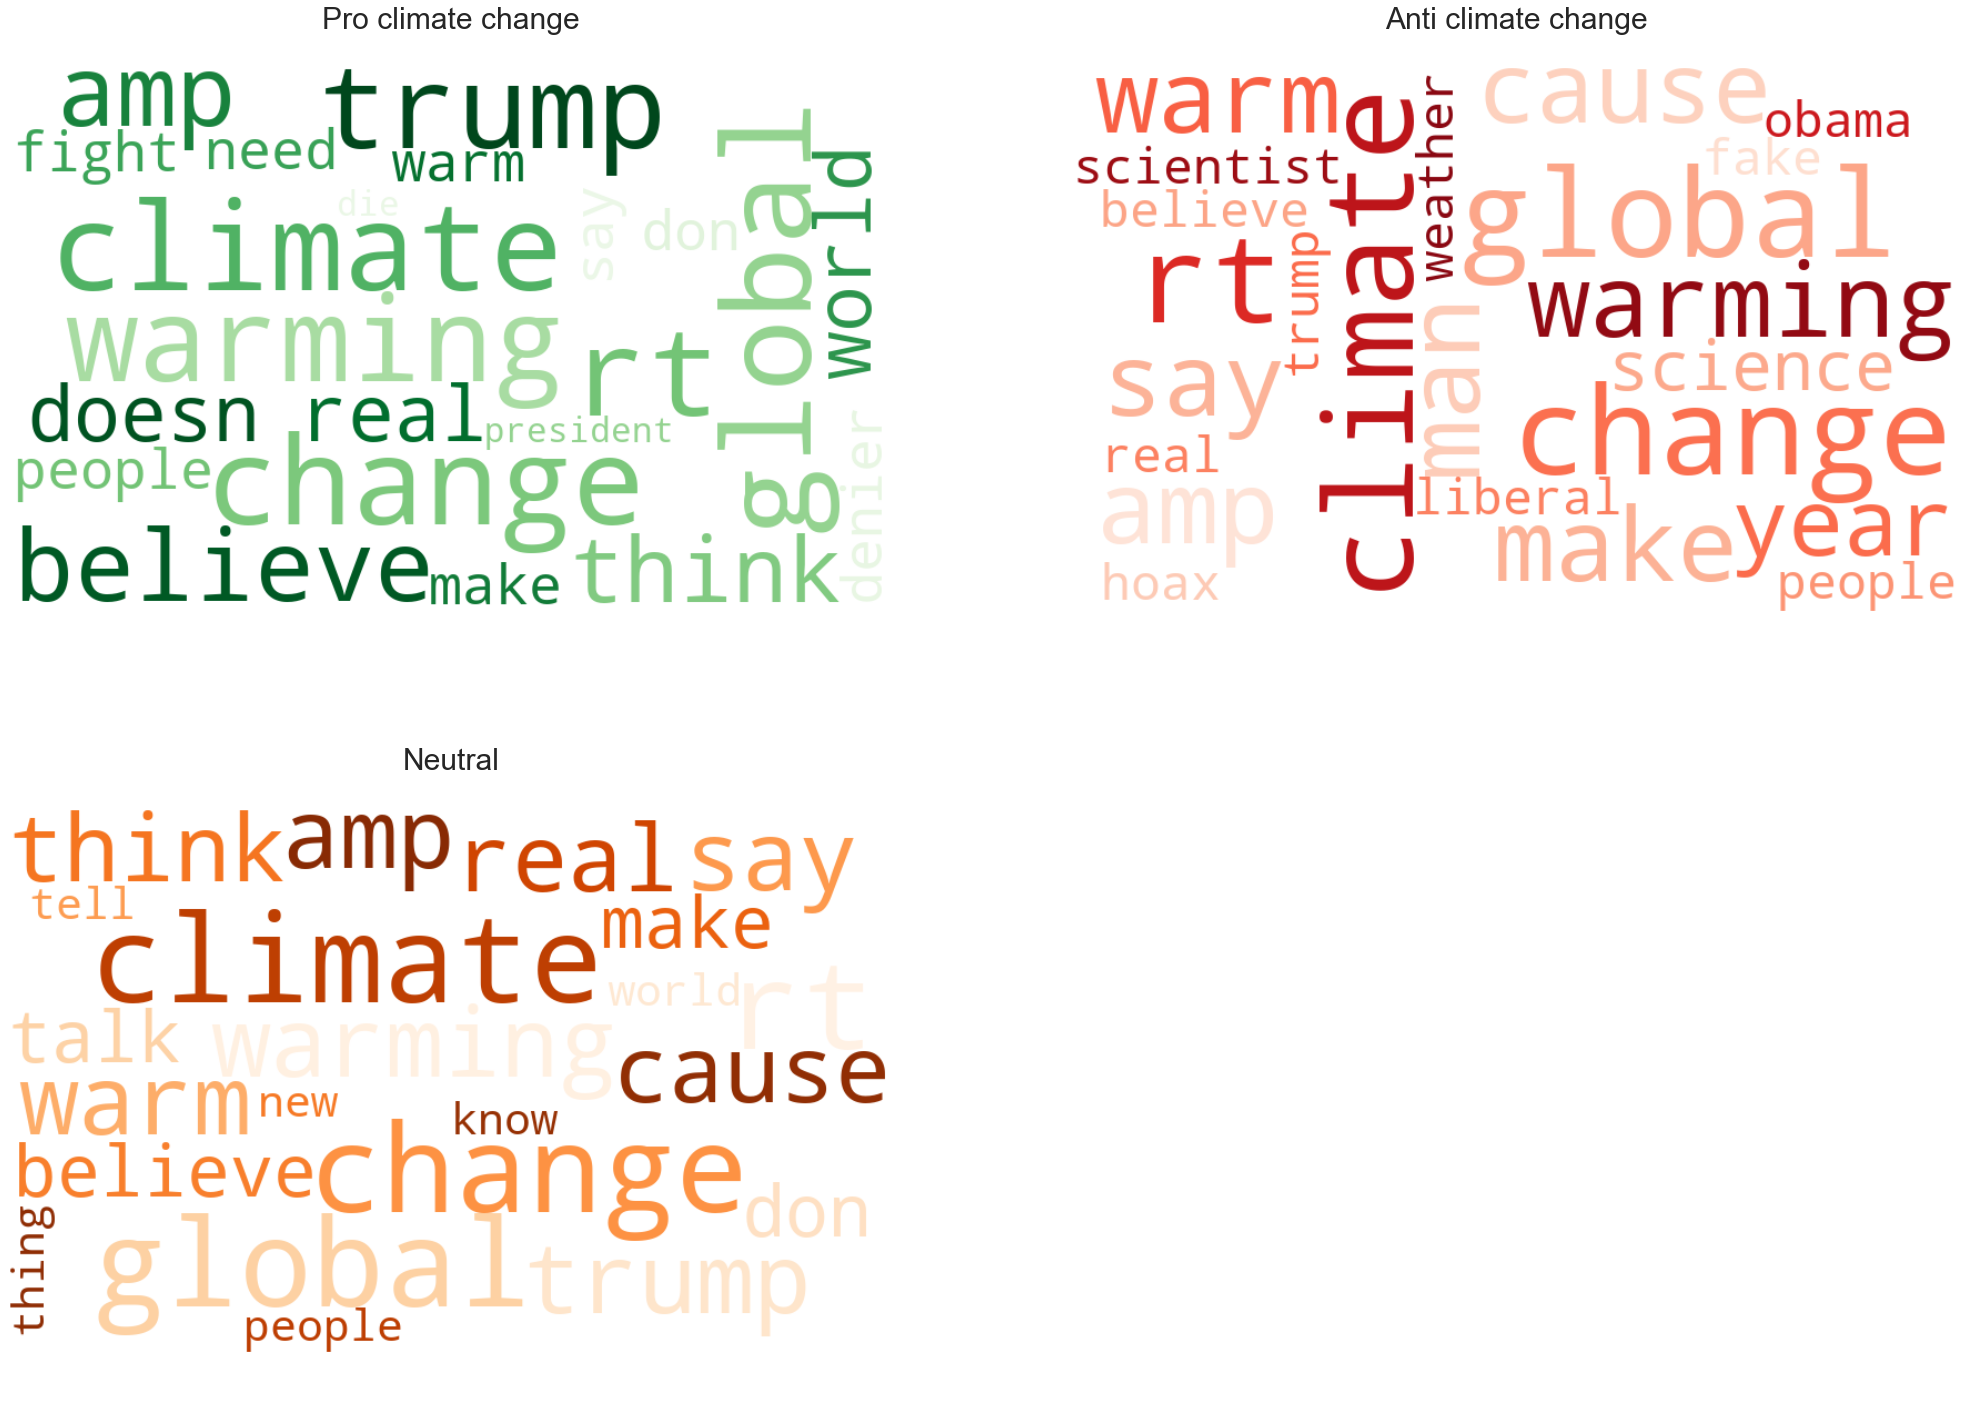

In [78]:
# Plot pro and anti wordclouds next to one another for comparisson
f, axarr = plt.subplots(2,2, figsize=(35,25))
axarr[0,0].imshow(pro_wordcloud, interpolation="bilinear")
axarr[0,1].imshow(anti_wordcloud, interpolation="bilinear")
axarr[1,0].imshow(neutral_wordcloud, interpolation="bilinear")

# Remove the ticks on the x and y axes
for ax in f.axes:
    plt.sca(ax)
    plt.axis('off')

axarr[0,0].set_title('Pro climate change\n', fontsize=30)
axarr[0,1].set_title('Anti climate change\n', fontsize=30)
axarr[1,0].set_title('Neutral\n', fontsize=30)
#plt.tight_layout()
plt.show()

# Visualize top hashtags for each class 

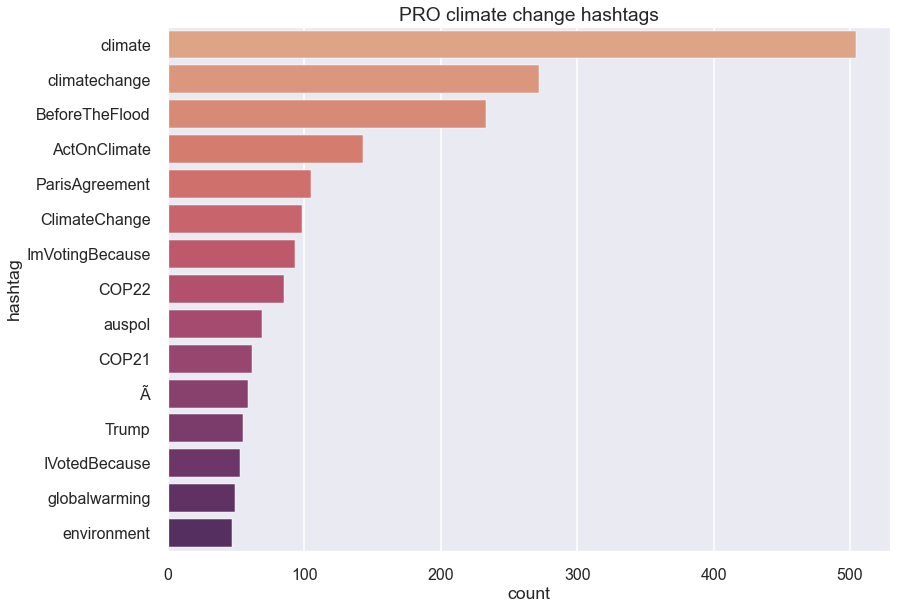

In [79]:
# Plot the frequent hastags for pro climate change classes
sns.barplot(data=pro,y=pro['hashtag'], x=pro['count'], palette=("flare"))
plt.title('PRO climate change hashtags')
plt.tight_layout()

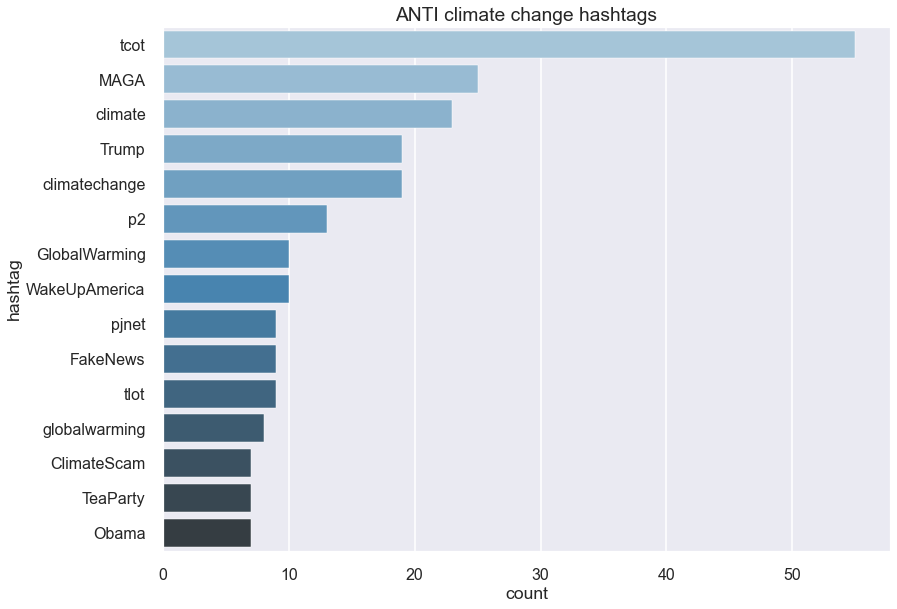

In [80]:
# Plot the frequent hastags for anti climate change classes
sns.barplot(data=anti,y=anti['hashtag'], x=anti['count'], palette=("Blues_d"))
plt.title('ANTI climate change hashtags')
plt.tight_layout()

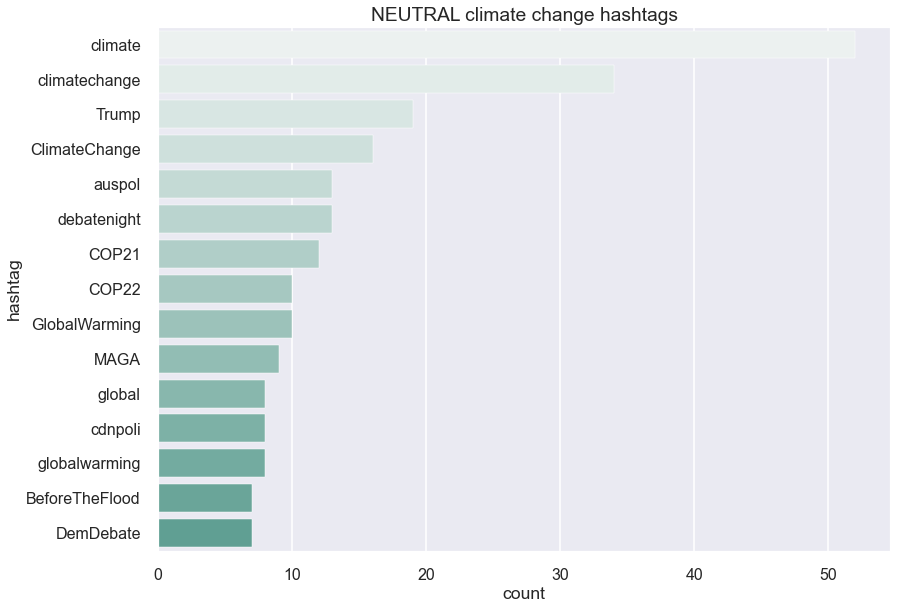

In [81]:
# Plot the frequent hastags for the neutral classes
sns.barplot(y=neutral['hashtag'], x=neutral['count'], palette=("light:#5A9"), )
plt.title('NEUTRAL climate change hashtags')
plt.tight_layout()


In [82]:
df.head()

,sentiment,message,tweetid,length,tokenized,pos_tags,lemmatized
0,Anti,climate change is an interesting hustle as it ...,792927353886371840,122,"[climate, change, is, an, interesting, hustle,...","[(climate, n), (change, n), (is, v), (an, n), ...",climate change be an interesting hustle a it b...
1,Pro,rt watch right here as travels the world to ta...,793124211518832641,76,"[rt, watch, right, here, as, travels, the, wor...","[(rt, n), (watch, n), (right, r), (here, r), (...",rt watch right here a travel the world to tack...
2,Pro,fabulous leonardo s film on change is brillian...,793124402388832256,61,"[fabulous, leonardo, s, film, on, change, is, ...","[(fabulous, a), (leonardo, n), (s, n), (film, ...",fabulous leonardo s film on change be brillian...
3,Pro,rt just watched this amazing documentary by le...,793124635873275904,104,"[rt, just, watched, this, amazing, documentary...","[(rt, n), (just, r), (watched, v), (this, n), ...",rt just watch this amazing documentary by leon...
5,Neutral,unamshow awache kujinga na iko global warming,793125429418815489,46,"[unamshow, awache, kujinga, na, iko, global, w...","[(unamshow, a), (awache, n), (kujinga, n), (na...",unamshow awache kujinga na iko global warming
